# Failure of losses relaxation

Illustration of when the $$P_{losses} \geq \text{convex expression}$$inequality is not tight. I.e. emergence of extraneous losses.

In [1]:
using Printf
using JuMP
# Solvers
using Ipopt
using ECOS
# Plot
using PyPlot

## Scenario

PV production, injected with a soft power limit (excess power is penalized)

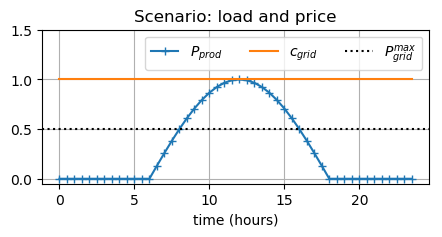

E_prod: 7.629 kWh

In [103]:
# Time vector: 2 hours, 0.1 h time step
n = 2*24
dt = 0.5
t = collect((0:n-1)*dt);

E_rated = 2.0 # kWh
P_grid_max = 0.5 # kW
P_prod = max.(-cos.(2*pi*t/24), 0.)
c_grid = ones(n)*1.0 # €/kWh

figure(figsize=(5,2.))
plot(t, P_prod, "+-", label="\$P_{prod}\$")
plot(t, c_grid, label="\$c_{grid}\$")
axhline(P_grid_max, ls=":", color="k", label="\$P_{grid}^{max}\$")
xlabel("time (hours)")
ylim(ymax=1.5)
title("Scenario: load and price")
legend(ncol=3)
grid(true)

@printf("E_prod: %.3f kWh", sum(P_load*dt))

In [104]:
ρ0 = 0.1 # kW/kW²

0.1

In [147]:
optimizer = ECOS.Optimizer

m = Model(optimizer)
# silence solver output
set_silent(m)

cex = 1.5

# Variables:
@variable(m, 0. <= Eb[1:n+1] <= E_rated) # storage energy
@variable(m, Pb[1:n]) # storage power
@variable(m, P_losses[1:n]) # storage losses
@variable(m, 0. <= P_grid[1:n]) # grid power
@variable(m, 0. <= P_gex[1:n]) # excess of grid power
@variable(m, C_grid) # Total grid cost
@variable(m, C_gex) # Total excess power cost


# Excess power should be max(P_grid - P_grid_max, 0)
@constraint(m, gex[k = 1:n],
            P_gex[k] >= P_grid[k] - P_grid_max)
# Power flow
@constraint(m, Pcons[k = 1:n],
            P_grid[k] == P_prod[k] - Pb[k])
# Storage dynamics
@constraint(m, Edyn[k = 1:n], 
            Eb[k+1] == Eb[k] + (Pb[k] - P_losses[k])*dt)
# Initial energy: empty
@constraint(m, Eb_ini, Eb[1] == 0.)
# Total grid cost
@constraint(m, C_grid == sum(P_grid .* c_grid)*dt)
@constraint(m, C_gex == cex * sum(P_gex .* c_grid)*dt)

# Losses
#@constraint(m, losses, m[:P_losses] .>= 0.001*ρ0 * m[:Pb].^2)
@constraint(m, losses, m[:P_losses] .== 0.001*m[:Eb][1:end-1])
#@constraint(m, losses, m[:P_losses] .>= 0.001*m[:Eb][1:end-1])
#@constraint(m, losses, m[:P_losses] .>= 0.0)
#@constraint(m, losses, m[:P_losses] .== 0.0)

seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = seq0_1 * 1e-5

@objective(m, Max, C_grid - C_gex + sum(m[:P_grid] .* discount) );

In [148]:
optimize!(m)
@printf("C_grid: %.3f\n", value(C_grid))
@printf("C_gex:  %.3f\n", value(C_gex))
@printf("Delta:  %.3f\n", value(C_grid) - value(C_gex))

C_grid: 7.613
C_gex:  0.897
Delta:  6.716


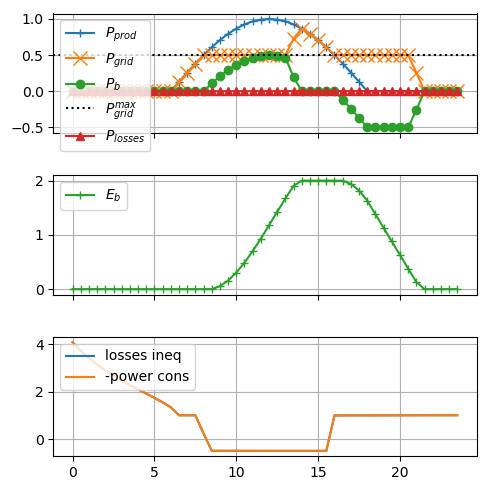

In [149]:
P_grid = value.(m[:P_grid])
Pb = value.(m[:Pb])
Eb = value.(m[:Eb])
P_losses = value.(m[:P_losses])


fig, ax = subplots(3,1, sharex=true, figsize=(5,5))
ax[1].plot(t, P_prod, "+-", label="\$P_{prod}\$")
ax[1].plot(t, P_grid, "x-", label="\$P_{grid}\$", ms=10)
ax[1].plot(t, Pb, "o-", label="\$P_b\$")
ax[1].axhline(P_grid_max, ls=":", color="k", label="\$P_{grid}^{max}\$")

ax[2].plot(t, Eb[1:end-1], "C2+-", label="\$E_b\$")
ax[1].plot(t, P_losses, "C3^-", label="\$P_{losses}\$")

ax[3].plot(t, dual.(m[:losses])/dt, label="losses ineq")
ax[3].plot(t, -dual.(m[:Pcons])/dt, label="-power cons")


for axi in ax
    axi.grid(true)
    axi.legend(loc="upper left")
end

tight_layout()

In [159]:
Interact.WebIO.install_jupyter_labextension() # might be helpful if you see `WebIO` warnings in Jupyter

┌ Info: Using default Jupyter executable at `/home/pierre/Programmes/miniconda3.7/bin/jupyter`; to use a different executable, see the documentation by running `?WebIO.install_jupyter_labextension`.
└ @ WebIO /home/pierre/.julia/packages/WebIO/Fy9h1/deps/jupyter.jl:198


An error occured.
ValueError: No linked package for @webio/webio
See the log file for details:  /tmp/jupyterlab-debug-b5781buj.log


Uninstalling @webio/jupyter-lab-provider from /home/pierre/Programmes/miniconda3.7/share/jupyter/lab/extensions


[LabBuildApp] JupyterLab 2.2.6
[LabBuildApp] Building in /home/pierre/Programmes/miniconda3.7/share/jupyter/lab
[LabBuildApp] Building jupyterlab assets (build:prod:minimize)


Process(`/home/pierre/Programmes/miniconda3.7/bin/jupyter lab build`, ProcessExited(0))

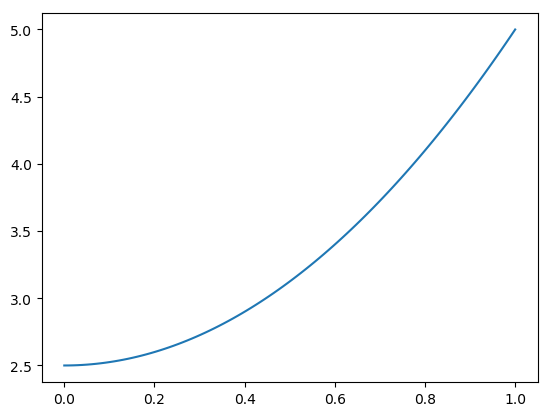

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["λ"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 51,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict(

In [160]:
using Interact
## 
@manipulate throttle=.05 for λ=0:.1:5, μ=0:.1:5
    xs = range(0.0, 1.0, length = 100)
    plot(xs, λ*xs.^2 .+ μ)
end